# Install and import necessary dependencies

In [1]:
!pip install  keras_core keras_nlp 

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Input,Embedding,Flatten,TextVectorization,Conv1D,GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.layers import Dense,LSTM,Bidirectional,Attention,Concatenate,GRU,BatchNormalization
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Enable multiple gpus
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')


Using 2 GPUs


In [4]:
import pandas as pd
import numpy as np
data=pd.read_csv('/kaggle/input/smart-contract-vulnerability-datset/SC_4label.csv')
data

,Unnamed: 0,filename,code,label,label_encoded
0,0,36375.sol,pragma solidity ^0.4.15;\n\n/*\n\n CJX.io -...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
1,1,40298.sol,// <ORACLIZE_API>\n/*\nCopyright (c) 2015-2016...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
2,2,39858.sol,pragma solidity ^0.4.6;\n\n/*\n Copyright 2...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
3,3,34598.sol,pragma solidity ^0.4.4;\n\ncontract Token {\n\...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
4,4,33490.sol,pragma solidity ^0.4.13;\n\ncontract DSAuthori...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
...,...,...,...,...,...
2212,2212,9695.sol,\ncontract ERC223ReceivingContract {\n\n ...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2213,2213,8615.sol,pragma solidity ^0.4.13;\n\ncontract ERC20Basi...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2214,2214,7877.sol,pragma solidity ^0.4.24;\npragma experimental ...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2215,2215,6604.sol,pragma solidity 0.4.24;\n\n \n\n \nlibrary Saf...,/content/drive/My Drive/SC_Dataset/timestamp d...,3


# Label distribution

In [5]:
data['label_encoded'].value_counts()

label_encoded
2    1218
1     590
3     312
0      97
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of vulnerabilities')

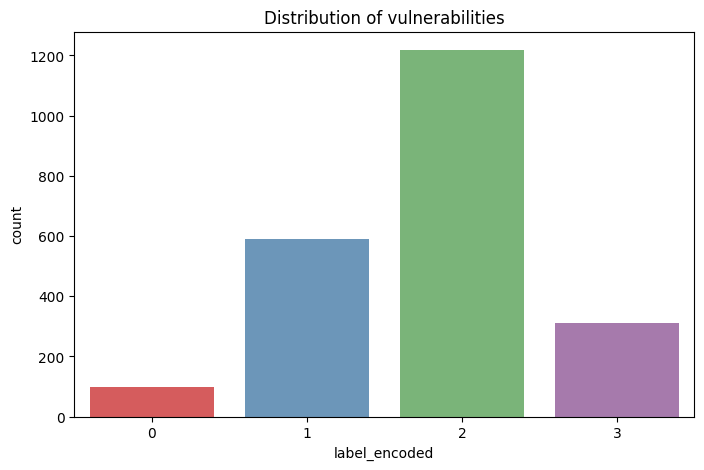

In [6]:
plt.figure(figsize = (8,5))
sns.countplot(x = data['label_encoded'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of vulnerabilities')

# Preprocessing dataset

In [7]:
X = data['code']
y = data['label_encoded']

In [8]:
solidity_stopwords = [
    "pragma", "interface", "contract", "function", "event", "modifier", "library", "using",
    "string", "uint8", "uint256", "address", "mapping", "bool", "require", "return", "memory",
    "storage", "public", "internal", "view", "returns", "constant", "constructor",
    "_owner", "_balances", "_allowances", "_founder", "_marketing", "_who", "_burntAmount",
    "_from", "_to", "_value", "_timestamp", "_bool", "msg.sender", "totalSupply",
    "balanceOf", "transfer", "allowance", "approve", "transferFrom", "add", "sub", "mul", "div",
    "mod", "changeFounder", "setMinter", "setFurnace", "freezeAccount","solidity","bytes32"
]
def clean_solidity_code(solidity_code):
    # Remove comments (both single-line and multi-line)
    cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
    cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)

    # Remove special characters and punctuation
    cleaned_code = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_code)

    # Remove extra whitespace and blank lines, and convert to lowercase
    cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())

    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in cleaned_code.split() if word not in stop_words]
    tokens = [token for token in tokens if token not in solidity_stopwords]
    cleaned_code = ' '.join(tokens)

    return tokens

In [9]:
X_cleaned = X.apply(clean_solidity_code)

In [10]:
# Join the tokenized words back into sentences
X_cleaned_sentences = [' '.join(doc) for doc in X_cleaned]

In [11]:
X_cleaned_sentences=np.array(X_cleaned_sentences)

In [12]:
X_cleaned_sentences[1]

'oraclizei cbaddress queryuint timestamp datasource arg id querywithgaslimituint timestamp datasource arg uint gaslimit id query2uint timestamp datasource arg1 arg2 id query2withgaslimituint timestamp datasource arg1 arg2 uint gaslimit id getpricestring datasource uint dsprice getpricestring datasource uint gaslimit uint dsprice usecouponstring coupon setprooftypebyte prooftype setcustomgaspriceuint gasprice oraclizeaddrresolveri getaddress addr usingoraclize uint day 606024 uint week 6060247 uint month 60602430 byte prooftypenone 0x00 byte prooftypetlsnotary 0x10 byte proofstorageipfs 0x01 networkidauto 0 networkidmainnet 1 networkidtestnet 2 networkidmorden 2 networkidconsensys 161 oraclizeaddrresolveri oar oraclizei oraclize oraclizeapi oraclizeaddr oargetaddress oraclizeaddr 0 oraclizesetnetworknetworkidauto oraclizeaddr oargetaddress oraclize oraclizeioraclizeaddr couponstring code oraclize oraclizeioargetaddress oraclizeusecouponcode oraclizesetnetworkuint8 networkid returnsbool 

In [13]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sentences, y,
                                                    test_size=0.1,shuffle=True,random_state=42,stratify=y)

# Tokenize and padding

In [14]:
# one hot encoding label
y_train_encoded = to_categorical(y_train, 4)
y_test_encoded = to_categorical(y_test, 4)
y_train_encoded

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [15]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [16]:
# Padding the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=128, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=128, padding='post', truncating='post')


In [17]:
print('Shape of training tensor: ', X_train_padded.shape)
print('Shape of testing tensor: ', X_test_padded.shape)

Shape of training tensor:  (1995, 128)
Shape of testing tensor:  (222, 128)


# Optional: Oversampling dataset using SMOTE

In [18]:
#Smote oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
import math

In [19]:
def smote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy=1, 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y

In [20]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train_encoded)

In [21]:
y_train_resampled

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [22]:
label_counts = np.sum(y_train_resampled, axis=0)

# Display the label counts
print("Label Counts:", label_counts)

Label Counts: [1096  531 1096  281]


In [23]:
#getting the length of the maximum sequence in the dataset
max_length = max([len(w) for w in X_train])
print(max_length)

40222


In [24]:
emb_len=len(tokenizer.index_word)+1

# Attention based BiLSTM CNN

In [25]:
# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Bidirectional LSTM layer replaced with Attention layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer

# 1D Convolutional layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)

# GlobalMaxPooling1D layer
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)

output_layer = Dense(4, activation='softmax')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 128)             5820160   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 128, 256)             263168    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 128, 256)             0         ['bidirectional[0][0]',   

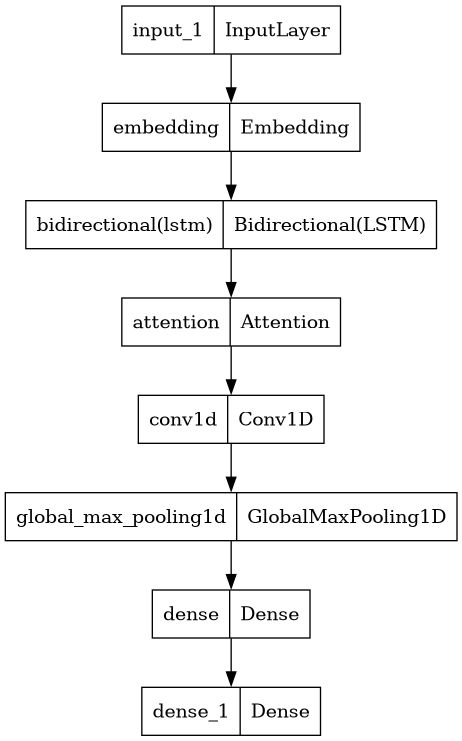

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
checkpoint_path = 'training/best_model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [30]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=True)

In [31]:
#Trainig the model
history = model.fit(X_train_padded,y_train_encoded,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_padded,y_test_encoded),
                    callbacks=[model_checkpoint_callback,early_stop])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.6331
Epoch 1: val_accuracy improved from -inf to 0.78378, saving model to training/best_model.ckpt
63/63 [==============================] - 80s 1s/step - loss: 0.8750 - accuracy: 0.6331 - val_loss: 0.5482 - val_accuracy: 0.7838
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8551
Epoch 2: val_accuracy improved from 0.78378 to 0.85586, saving model to training/best_model.ckpt
63/63 [==============================] - 67s 1s/step - loss: 0.4240 - accuracy: 0.8551 - val_loss: 0.3963 - val_accuracy: 0.8559
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9188
Epoch 3: val_accuracy improved from 0.85586 to 0.90541, saving model to training/best_model.ckpt
63/63 [==============================] - 65s 1s/step - loss: 0.2580 - accuracy: 0.9188 - val_loss: 0.2905 - val_accuracy: 0.9054
Epoch 4/20
63/63 [=========================

In [32]:
#Load best model
model.load_weights(checkpoint_path)

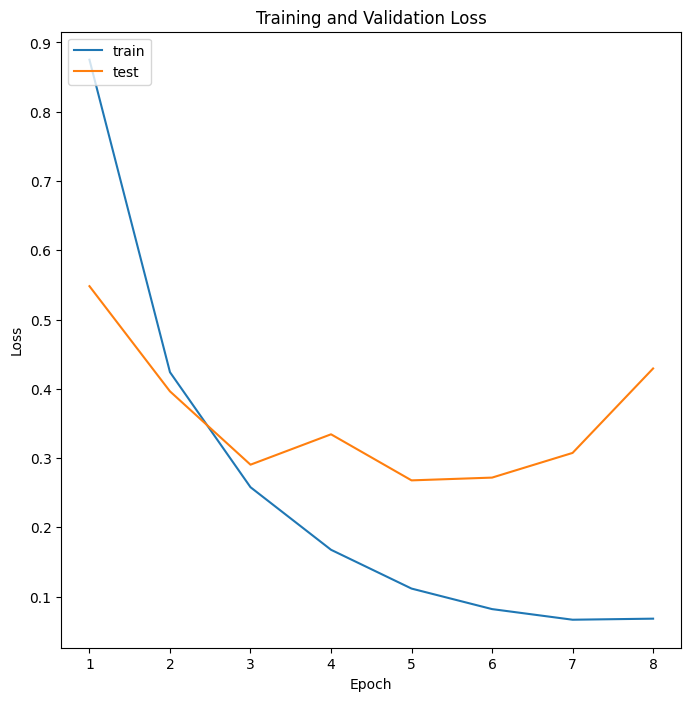

In [33]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs,train_metric,label = f'Training {metric}')
    plt.plot(epochs,val_metric,label = f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'],loc='upper left')
    plt.show()
#Training and validation loss plot
plot_metrics(history, metric='loss')

In [34]:
## Evaluate Model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

7/7 [==============================] - 0s 67ms/step - loss: 0.2718 - accuracy: 0.9234
Validation Loss: 0.27183786034584045, Validation Accuracy: 0.9234234094619751


In [35]:
#prediction
y_pred = model.predict(X_test_padded)
y_pred_class = y_pred.argmax(axis=1)

7/7 [==============================] - 1s 64ms/step


In [36]:
labels=['DC','IO','RE','TD']

In [37]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_class,target_names=labels)
print(report)

              precision    recall  f1-score   support

          DC       0.89      0.80      0.84        10
          IO       0.84      0.92      0.88        59
          RE       0.97      0.95      0.96       122
          TD       0.90      0.87      0.89        31

    accuracy                           0.92       222
   macro avg       0.90      0.88      0.89       222
weighted avg       0.93      0.92      0.92       222



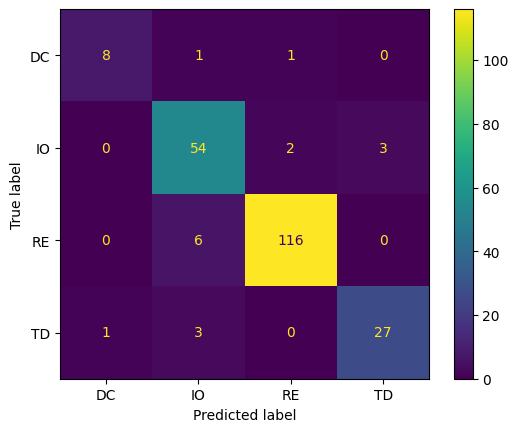

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

# DeBERTA V3

In [39]:
import keras_core as keras
import keras_nlp

Using TensorFlow backend


In [40]:
# Load a DistilBERT model.
preset= "deberta_v3_base_en"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(preset,
                                                                   sequence_length=256,
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=4)

classifier.summary()

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/li

Preprocessor: "deberta_v3_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deberta_v3_tokenizer (DebertaV3Tokenizer)          │                                             128,001 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "deberta_v3_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ deberta_v3_backbone (DebertaV3Backbone)       │ (None, None, 768)                      │     183,831,552 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 4)                              │           3,076 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 184,425,220 (703.53 MB)

 Trainable params: 184,425,220 (703.53 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
checkpoint_path = 'training/best_model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [42]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=True,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [43]:
# Compile
classifier.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

In [44]:
# Fit
history = classifier.fit(x=X_train,
                         y=y_train_encoded,
                         batch_size=16,
                         epochs=10,
                         validation_data=(X_test,y_test_encoded),
                         callbacks=[early_stop]
                        )

Epoch 1/10
125/125 [==============================] - 248s 2s/step - loss: 0.9251 - accuracy: 0.6481 - val_loss: 0.6698 - val_accuracy: 0.7342
Epoch 2/10
125/125 [==============================] - 173s 1s/step - loss: 0.6200 - accuracy: 0.7794 - val_loss: 0.4906 - val_accuracy: 0.8243
Epoch 3/10
125/125 [==============================] - 172s 1s/step - loss: 0.4905 - accuracy: 0.8306 - val_loss: 0.3971 - val_accuracy: 0.8784
Epoch 4/10
125/125 [==============================] - 171s 1s/step - loss: 0.4060 - accuracy: 0.8602 - val_loss: 0.4057 - val_accuracy: 0.8649
Epoch 5/10
125/125 [==============================] - 172s 1s/step - loss: 0.3281 - accuracy: 0.8872 - val_loss: 0.3846 - val_accuracy: 0.8874
Epoch 6/10
125/125 [==============================] - 171s 1s/step - loss: 0.2851 - accuracy: 0.9068 - val_loss: 0.4766 - val_accuracy: 0.8514
Epoch 7/10
125/125 [==============================] - 171s 1s/step - loss: 0.2720 - accuracy: 0.9093 - val_loss: 0.4540 - val_accuracy: 0.8649

In [45]:
test_loss, test_accuracy=classifier.evaluate(X_test,y_test_encoded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

7/7 [==============================] - 7s 889ms/step - loss: 0.3846 - accuracy: 0.8874
Test Loss: 0.38464999198913574, Test Accuracy: 0.8873873949050903


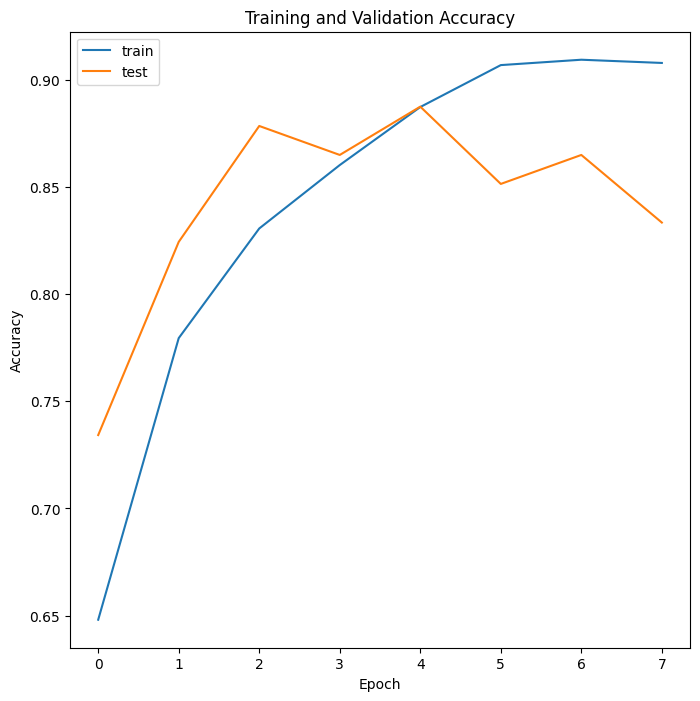

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8,8))
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label = 'Validation Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Training and Validation Accuracy.pdf')
plt.show()

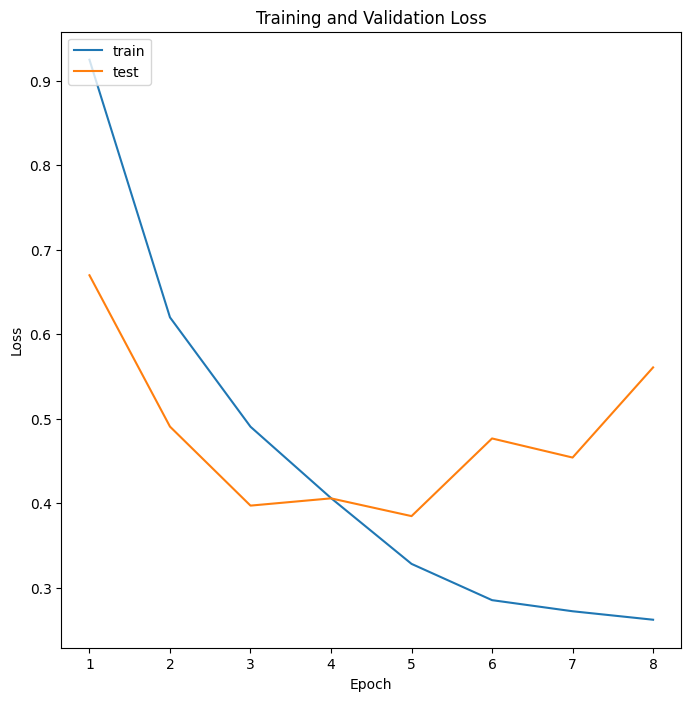

In [47]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs,train_metric,label = f'Training {metric}')
    plt.plot(epochs,val_metric,label = f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'],loc='upper left')
    plt.show()
#Training and validation loss plot
plot_metrics(history, metric='loss')

In [48]:
#prediction
y_pred = classifier.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)

7/7 [==============================] - 11s 879ms/step


In [49]:
labels=['DC','IO','RE','TD']

In [50]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_class,target_names=labels)
print(report)

              precision    recall  f1-score   support

          DC       0.89      0.80      0.84        10
          IO       0.81      0.88      0.85        59
          RE       0.97      0.93      0.95       122
          TD       0.74      0.74      0.74        31

    accuracy                           0.89       222
   macro avg       0.85      0.84      0.84       222
weighted avg       0.89      0.89      0.89       222



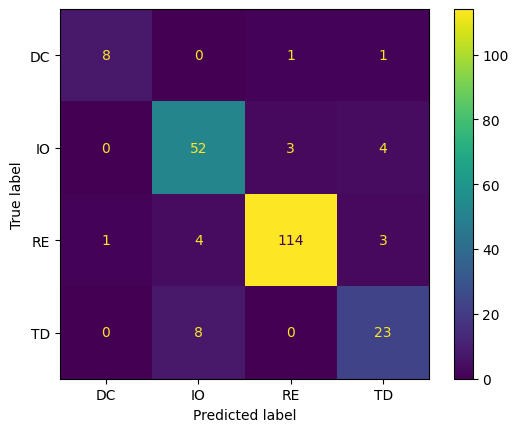

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()